In [1]:
!mkdir -p data/house-prices

In [2]:
!unzip -o data/house-prices-advanced-regression-techniques.zip -d data/house-prices

Archive:  data/house-prices-advanced-regression-techniques.zip
  inflating: data/house-prices/data_description.txt  
  inflating: data/house-prices/sample_submission.csv  
  inflating: data/house-prices/test.csv  
  inflating: data/house-prices/train.csv  


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

seed = np.random.RandomState(31337)

In [4]:
train = pd.read_csv("data/house-prices/train.csv")

train.shape

(1460, 81)

In [5]:
test = pd.read_csv("data/house-prices/test.csv")

test.shape

(1459, 80)

In [6]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# keep only numerical features
X_train = train.select_dtypes(include=["number"]).copy()
X_test = test.select_dtypes(include=["number"]).copy()

In [8]:
# drop target variable from our training dataset
X_train = X_train.drop(["SalePrice"], axis=1)

In [9]:
X_train["adval_label"] = 1.0

In [10]:
X_test["adval_label"] = 0.0

In [11]:
# combine training & test datasets
combined_dataset = pd.concat([X_train, X_test], axis=0, ignore_index=True)

combined_dataset.shape

(2919, 38)

In [12]:
combined_dataset.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'adval_label'],
      dtype='object')

In [13]:
# shuffle it
combined_dataset_shuffled = combined_dataset.sample(frac=1)

In [14]:
X = combined_dataset_shuffled.drop(["adval_label"], axis=1)

In [15]:
X = X.drop(["Id"], axis=1)

In [16]:
y = combined_dataset_shuffled["adval_label"]

In [17]:
n_splits = 6
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
classifier = xgb.XGBClassifier()

  0%|          | 0/6 [00:00<?, ?it/s]

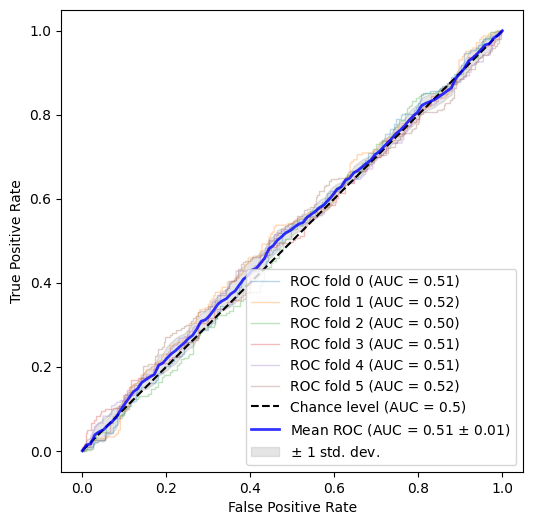

In [18]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))


for fold, (train, test) in tqdm([*enumerate(cv.split(X, y))]):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

In [19]:
aucs

[0.5101868717533562,
 0.5219338190649666,
 0.5020407474870134,
 0.508459076360311,
 0.5114989246219241,
 0.5185693237819439]